# Step 0: Input Preparation

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from src.utils.sys_utils import create_dir

# Constants
ANNOTATIONS_FILEPATH = "./data/ldsi_w21_curated_annotations_v2.json"
UNLABELED_DATA_DIR = "./data/unlabeled/"

OUT_DIR = "./out/"
GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH = OUT_DIR + "_generated_tokens_for_embeddings.txt"
EMBEDDINGS_MODEL_FILEPATH = OUT_DIR + "_embeddings_model.bin"
BEST_CLASSIFIER_FILEPATH = OUT_DIR + "_best_classifier.pkl"

# Create the out directory
create_dir(OUT_DIR)

# Step 1: Dataset Splitting

In [2]:
from src.corpus import Corpus

# Initialize the Corpus
corpus = Corpus(ANNOTATIONS_FILEPATH, UNLABELED_DATA_DIR)
print(corpus)

Log (2022-03-05 01:55:04.793752): Loading the labeled data..
Log (2022-03-05 01:55:04.864883): 540 documents loaded, 141 of which are annotated!
Log (2022-03-05 01:55:04.866962): Loading the unlabeled data..


100%|██████████| 30000/30000 [00:07<00:00, 4194.78it/s]

Log (2022-03-05 01:55:12.176705): 30000 unlabeled documents loaded!
Corpus summary:
Validation set: ['61aea55e97ad59b4cfc412e6', '61aea55e97ad59b4cfc412fd', '61aea57097ad59b4cfc41365', '61aea55e97ad59b4cfc412d4', '61aea55f97ad59b4cfc41322', '61aea57397ad59b4cfc41393', '61aea55f97ad59b4cfc41328', '61aea55e97ad59b4cfc412d7', '61aea57497ad59b4cfc413e7', '61aea57297ad59b4cfc41382', '61aea57497ad59b4cfc413c4', '61aea57397ad59b4cfc413a7', '61aea55d97ad59b4cfc412d2', '61aea57497ad59b4cfc413b2']
Test set: ['61aea55f97ad59b4cfc41301', '61aea57497ad59b4cfc413bd', '61aea55f97ad59b4cfc4131a', '61aea57097ad59b4cfc4135a', '61aea55c97ad59b4cfc412af', '61aea55f97ad59b4cfc41334', '61aea55d97ad59b4cfc412bf', '61aea57497ad59b4cfc413be', '61aea56f97ad59b4cfc41342', '61aea55c97ad59b4cfc41299', '61aea57097ad59b4cfc41355', '61aea55f97ad59b4cfc41307', '61aea57097ad59b4cfc4135e', '61aea57097ad59b4cfc41361']


# Step 2: Sentence Segmentation

In [3]:
from src.segmentation.spacy_segmenter import SpacySegmenter
from src.segmentation.luima_law_segmenter import LuimaLawSegmenter

# Initialize the segmenters
segmenters = {
    # Step 2.1: Standard segmentation analysis
    "NaiveSpacySegmenter": SpacySegmenter(corpus=corpus),
    # Step 2.2: Improved segmentation analysis
    "ImprovedSpacySegmenter": SpacySegmenter(corpus=corpus, improved=True),
    # Step 2.3: A law-specific sentence segmenter analysis (Luima)
    "LuimaLawSegmenter": LuimaLawSegmenter(corpus=corpus)
}

## Step 2.1: Standard segmentation analysis

In [ ]:
segmenters["NaiveSpacySegmenter"].apply_segmentation(annotated=True, debug=True)

## Step 2.2: Improved segmentation analysis

In [ ]:
segmenters["ImprovedSpacySegmenter"].apply_segmentation(annotated=True, debug=True)

## Step 2.3: A law-specific sentence segmenter analysis (Luima)

In [ ]:
segmenters["LuimaLawSegmenter"].apply_segmentation(annotated=True, debug=True)

### Step 2.3.1: Relaxed error analysis for Luima segmentation by comparing only the start indices (not the end indices) of the splits

In [ ]:
segmenters["LuimaLawSegmenter"].error_analysis_metrics["deep_compare"] = False
segmenters["LuimaLawSegmenter"].apply_segmentation(annotated=True, debug=True)

# Step 3: Preprocessing

In [4]:
from src.tokenizer import Tokenizer

# Initialize the tokenizer
tokenizer = Tokenizer(segmenters)

# Generate or load sentences and tokens
# sentences, tokens = tokenizer.generate_unlabeled()  # Takes about 4 to 6 hours..
sentences_by_document, tokens_by_document = tokenizer.load_unlabeled()

# Write the tokens to a file to be used as an input to embedding computations
tokenizer.write_tokens_to_file_for_embeddings(sentences_by_document, tokens_by_document,
                                                        filepath=GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH)

# Sanity check
assert len(sentences_by_document) == len(tokens_by_document)

print("%d tokens generated from %d sentences" % (
    tokenizer.count_tokens(tokens_by_document),
    tokenizer.count_sentences(sentences_by_document)
))

Log (2022-03-05 01:55:13.956146): Loading the existing sentences generated from the unlabeled corpus..
Log (2022-03-05 01:55:19.384776): Loaded 3360495 sentences generated from the unlabeled corpus!
Log (2022-03-05 01:55:19.384942): Loading the existing tokens generated from the sentence-segmented decisions in the unlabeled corpus..
Log (2022-03-05 01:55:38.286382): Loaded 59403951 tokens generated from the sentence-segmented decisions in the unlabeled corpus!
Log (2022-03-05 01:55:38.286683): Flattening the sentences..
Log (2022-03-05 01:55:38.365420): Randomizing the sentences..
Log (2022-03-05 01:55:42.455990): Writing tokens to a file each line of which consists of a sentence's tokens, separated by a single whitespace..


100%|██████████| 3360495/3360495 [00:05<00:00, 616808.74it/s]


Log (2022-03-05 01:55:49.328619): Tokens generated from 2646783 of 3360495 sentences successfully written to ./out/_generated_tokens_for_embeddings.txt!
59403951 tokens generated from 3360495 sentences


## Step 3.1: Analyze sentences

Number of sentences in documents:
Max = 974
Average = 112


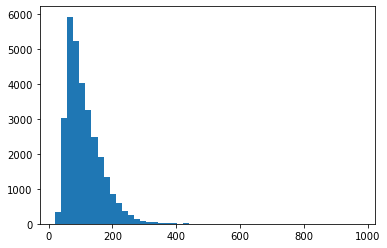

In [8]:
num_sentences_per_document = [len(sentences) for sentences in sentences_by_document.values()]

print("Number of sentences in documents:\nMax = %d\nAverage = %d" % (
    np.max(num_sentences_per_document), 
    np.mean(num_sentences_per_document)
))

plt.hist(num_sentences_per_document, bins=50)
plt.show()

## Step 3.2: Analyze tokens

Number of tokens in sentences:
Max = 20843
Average = 1980


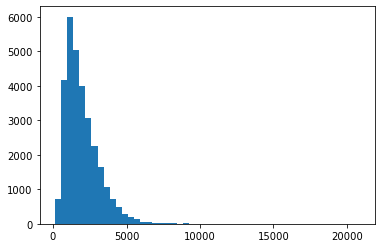

In [9]:
num_tokens_per_sentence = [
    sum([len(sentence_tokens) for sentence_tokens in sentences_with_tokens])
    for sentences_with_tokens in tokens_by_document.values()
]

print("Number of tokens in sentences:\nMax = %d\nAverage = %d" % (
    np.max(num_tokens_per_sentence), 
    np.mean(num_tokens_per_sentence)
))

plt.hist(num_tokens_per_sentence, bins=50)
plt.show()

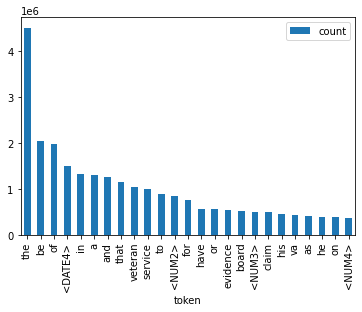

In [10]:
# Calculate token counts
token_counts = {}
for sentences_with_tokens in tokens_by_document.values():
    for sentence_tokens in sentences_with_tokens:
        for token in sentence_tokens:
            if token not in token_counts:
                token_counts[token] = 0
            
            token_counts[token] += 1

# Create token counts dataframe
token_counts_df = pd.DataFrame([{"token": token, "count": count} for (token, count) in token_counts.items()])
token_counts_df = token_counts_df.set_index(["token"])

# Plot token counts dataframe
token_counts_df.sort_values("count", ascending=False)[:25].plot.bar()
plt.show()

## Step 3.1: Free unused memory

In [11]:
del corpus.unlabeled_data
del sentences_by_document, tokens_by_document
del token_counts, token_counts_df

# Step 4: Developing Word Embeddings

In [12]:
from src.embeddings import Embeddings

## Step 4.1: Train a FastText Embeddings model

In [13]:
# Initialize an embeddings model
embeddings = Embeddings(model_filepath=EMBEDDINGS_MODEL_FILEPATH)

# Train the model from scratch
# embeddings.train(tokens_filepath=GENERATED_TOKENS_FOR_EMBEDDINGS_FILEPATH)

# Log the results
print("Vocabulary size: %d words and %d labels" % 
      (len(embeddings.model.words), len(embeddings.model.labels)))
print("Shape of the embeddings model: (%d, %d)" % 
      (np.shape(embeddings.model.words)[0], embeddings.model.get_dimension()))

Log (2022-03-05 01:56:27.799537): The embeddings model is being loaded..
Log (2022-03-05 01:56:28.632778): The embeddings model is successfully loaded!
Vocabulary size: 27734 words and 27734 labels
Shape of the embeddings model: (27734, 100)


## Step 4.2: Evaluating Embeddings via Nearest Neighbors

In [84]:
embeddings.get_nearest_neighbors([
    # Words recommended by the Professor
    "veteran", "v.", "argue", "ptsd", "grant", "korea", "holding", "also",
    # Additional words of interest
    "judge", "appear", "board", "evidence", "claim", "connection",
    "vietnam", "decision", "c.f.r", "38", "when"
])

{'veteran': [(0.7037935853004456, 'the'),
  (0.7011907696723938, 'his'),
  (0.6605009436607361, 'additionally'),
  (0.6467902064323425, 'that'),
  (0.6438310146331787, 'appellant'),
  (0.6436017155647278, 'he'),
  (0.639080286026001, 'furthermore'),
  (0.6119957566261292, 'have'),
  (0.5977565050125122, 'moreover'),
  (0.5874249339103699, 'futhermore')],
 'v.': [(0.31833115220069885, 'solutions'),
  (0.30697253346443176, 'candid'),
  (0.30605748295783997, 'emsh'),
  (0.30395159125328064, 'ems'),
  (0.2978612184524536, 'uncharacterized'),
  (0.2966495752334595, 'hearings'),
  (0.2942272126674652, 'aup'),
  (0.29248496890068054, 'conservation'),
  (0.29245901107788086, 'brevity'),
  (0.2917795181274414, 'llp')],
 'argue': [(0.7880198955535889, 'assert'),
  (0.7775487899780273, 'contend'),
  (0.6249223351478577, 'aver'),
  (0.60752272605896, 'reassert'),
  (0.5692722201347351, 'criticize'),
  (0.5613948106765747, 'misrepresentation'),
  (0.5590217709541321, 'reiterate'),
  (0.552304744720

# Step 5: Training Classifiers

In [85]:
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from src.featurization.tfidf_featurizer import TfidfFeaturizer
from src.featurization.embeddings_featurizer import EmbeddingsFeaturizer
from src.utils.classification_utils import test_classifier

X = {"TfidfFeaturizer": None, "EmbeddingsFeaturizer": None}
y = {"TfidfFeaturizer": None, "EmbeddingsFeaturizer": None}

## Step 5.1: TFIDF Featurization

In [86]:
tfidf_featurizer = TfidfFeaturizer(corpus, tokenization_segmenter=segmenters["ImprovedSpacySegmenter"])
tfidf_featurizer.vectorize()

X["TfidfFeaturizer"], y["TfidfFeaturizer"] = tfidf_featurizer.create_inputs_and_labels()

Log (2022-03-05 03:28:12.890037): Initializing a TfidfVectorizer and fitting it on the training data..
Log (2022-03-05 03:31:37.950000): TfidfVectorizer successfully initialized!
Log (2022-03-05 03:31:37.951189): Creating the inputs and labels for train, val and test sets..
Log (2022-03-05 03:31:37.951258): Adding tokens to the train spans..


100%|██████████| 12371/12371 [04:04<00:00, 50.58it/s]


Log (2022-03-05 03:35:42.546098): Tokens successfully added to the train spans!
Log (2022-03-05 03:35:42.550790): Adding tokens to the val spans..


100%|██████████| 1550/1550 [00:30<00:00, 51.00it/s]


Log (2022-03-05 03:36:12.952757): Tokens successfully added to the val spans!
Log (2022-03-05 03:36:12.953106): Adding tokens to the test spans..


100%|██████████| 1428/1428 [00:30<00:00, 46.62it/s]


Log (2022-03-05 03:36:43.594456): Tokens successfully added to the test spans!


  0%|          | 0/3 [00:00<?, ?it/s]

Log (2022-03-05 03:39:23.598276): Expanding the feature vector (train)..


 33%|███▎      | 1/3 [02:40<05:20, 160.47s/it]

Log (2022-03-05 03:39:24.054536): The feature vector (train) successfully expanded with 2 additional features!


 67%|██████▋   | 2/3 [02:54<01:14, 74.24s/it] 

Log (2022-03-05 03:39:37.892486): Expanding the feature vector (val)..
Log (2022-03-05 03:39:37.949865): The feature vector (val) successfully expanded with 2 additional features!


100%|██████████| 3/3 [03:07<00:00, 62.42s/it]

Log (2022-03-05 03:39:50.807810): Expanding the feature vector (test)..
Log (2022-03-05 03:39:50.862216): The feature vector (test) successfully expanded with 2 additional features!
Log (2022-03-05 03:39:50.867684): The inputs and labels successfully created for train, val and test sets!


## Step 5.2: Word Embedding Featurization

In [87]:
embeddings_featurizer = EmbeddingsFeaturizer(corpus, tokenization_segmenter=segmenters["ImprovedSpacySegmenter"],
                                             embeddings_model=embeddings.model)

X["EmbeddingsFeaturizer"], y["EmbeddingsFeaturizer"] = embeddings_featurizer.create_inputs_and_labels()

Log (2022-03-05 03:39:50.886685): Creating the inputs and labels for train, val and test sets..
Log (2022-03-05 03:39:50.887397): Adding tokens to the train spans..


100%|██████████| 12371/12371 [01:49<00:00, 112.95it/s]


Log (2022-03-05 03:41:40.419443): Tokens successfully added to the train spans!
Log (2022-03-05 03:41:40.419474): Adding tokens to the val spans..


100%|██████████| 1550/1550 [00:15<00:00, 98.83it/s] 


Log (2022-03-05 03:41:56.105441): Tokens successfully added to the val spans!
Log (2022-03-05 03:41:56.105477): Adding tokens to the test spans..


100%|██████████| 1428/1428 [00:14<00:00, 95.49it/s] 


Log (2022-03-05 03:42:11.062251): Tokens successfully added to the test spans!


 33%|███▎      | 1/3 [00:04<00:08,  4.21s/it]

Log (2022-03-05 03:42:15.255488): Expanding the feature vector (train)..
Log (2022-03-05 03:42:15.271974): The feature vector (train) successfully expanded with 2 additional features!


 67%|██████▋   | 2/3 [00:04<00:01,  1.95s/it]

Log (2022-03-05 03:42:15.631510): Expanding the feature vector (val)..
Log (2022-03-05 03:42:15.633844): The feature vector (val) successfully expanded with 2 additional features!


100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

Log (2022-03-05 03:42:15.960176): Expanding the feature vector (test)..
Log (2022-03-05 03:42:15.961933): The feature vector (test) successfully expanded with 2 additional features!
Log (2022-03-05 03:42:15.963996): The inputs and labels successfully created for train, val and test sets!


## Step 5.3: Finding the best models using the dev data

In [88]:
# Analyze the shapes
tfidf_featurizer.analyze_shapes(X["TfidfFeaturizer"], y["TfidfFeaturizer"])
embeddings_featurizer.analyze_shapes(X["EmbeddingsFeaturizer"], y["EmbeddingsFeaturizer"])

TfidfFeaturizer:
- The shapes of X_train and y_train are (12371, 3021) and (12371,) respectively.
- The shapes of X_val and y_val are (1550, 3021) and (1550,) respectively.
- The shapes of X_test and y_test are (1428, 3021) and (1428,) respectively.

EmbeddingsFeaturizer:
- The shapes of X_train and y_train are (12371, 102) and (12371,) respectively.
- The shapes of X_val and y_val are (1550, 102) and (1550,) respectively.
- The shapes of X_test and y_test are (1428, 102) and (1428,) respectively.



### Step 5.3.1: Linear Model - Linear Support Vector Machine Classifier

/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[TfidfFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       0.99      1.00      1.00       115
                          Citation       0.99      1.00      0.99      1963
                   ConclusionOfLaw       0.95      0.92      0.93       271
                          Evidence       0.90      0.96      0.93      3778
EvidenceBasedOrIntermediateFinding       0.82      0.80      0.81      1215
            EvidenceBasedReasoning       0.83      0.57      0.68       832
                            Header       0.99      0.99      0.99      1176
                         LegalRule       0.91      0.97      0.94      1520
              LegislationAndPolicy       0.85      0.48      0.61       132
              PolicyBasedReasoning       1.00      0.48      0

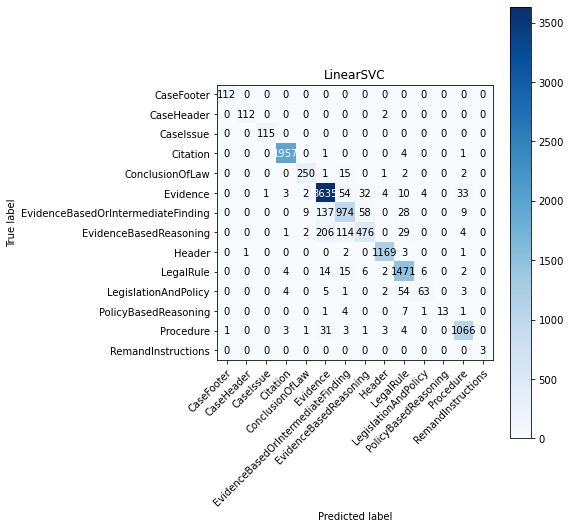

[TfidfFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.98      0.98      0.98       247
                   ConclusionOfLaw       0.79      0.74      0.76        35
                          Evidence       0.80      0.90      0.85       421
EvidenceBasedOrIntermediateFinding       0.58      0.58      0.58       134
            EvidenceBasedReasoning       0.50      0.19      0.28       141
                            Header       0.99      1.00      0.99       151
                         LegalRule       0.79      0.91      0.85       230
              LegislationAndPolicy       0.54      0.41      0.47        17
              PolicyBasedReasoning       0.00      0.00      0.0

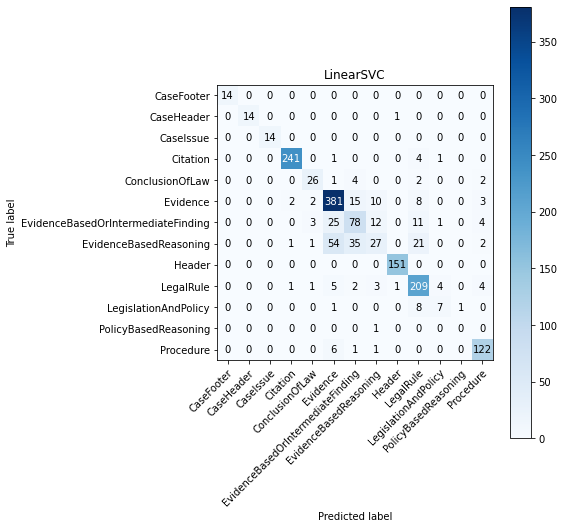

----------------------------------------------------------------------------------------------------


/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklear

[EmbeddingsFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.96      0.98       114
                         CaseIssue       0.93      0.97      0.94       115
                          Citation       0.97      0.98      0.98      1963
                   ConclusionOfLaw       0.81      0.71      0.76       271
                          Evidence       0.77      0.92      0.84      3778
EvidenceBasedOrIntermediateFinding       0.63      0.52      0.57      1215
            EvidenceBasedReasoning       0.51      0.11      0.18       832
                            Header       0.98      0.99      0.99      1176
                         LegalRule       0.78      0.90      0.83      1520
              LegislationAndPolicy       0.74      0.20      0.31       132
              PolicyBasedReasoning       0.00      0.00  

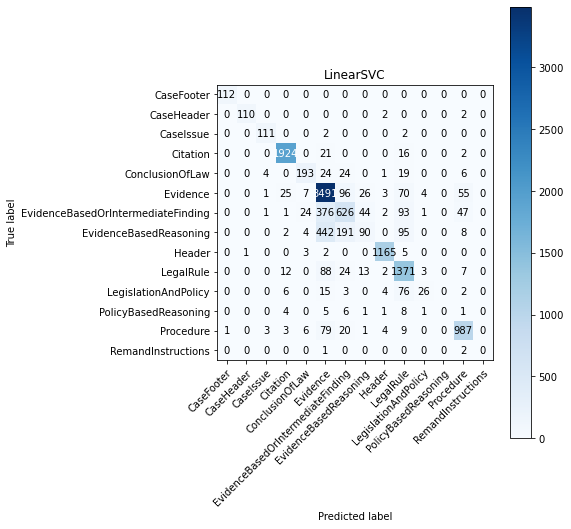

/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[EmbeddingsFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.98      0.98      0.98       247
                   ConclusionOfLaw       0.81      0.71      0.76        35
                          Evidence       0.76      0.91      0.83       421
EvidenceBasedOrIntermediateFinding       0.52      0.49      0.51       134
            EvidenceBasedReasoning       0.47      0.12      0.19       141
                            Header       0.99      1.00      0.99       151
                         LegalRule       0.79      0.91      0.85       230
              LegislationAndPolicy       0.44      0.24      0.31        17
              PolicyBasedReasoning       0.00      0.00    

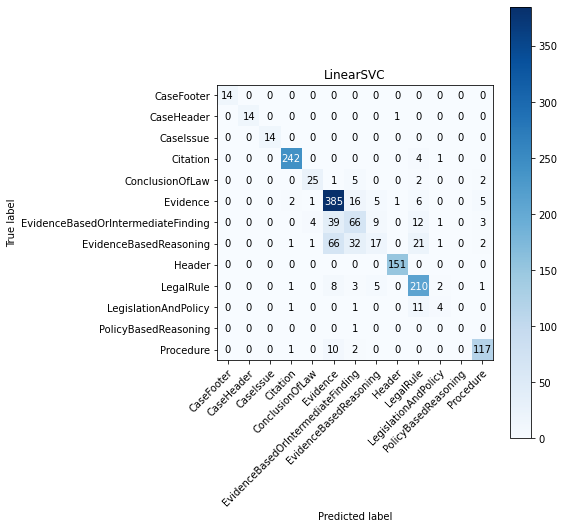

----------------------------------------------------------------------------------------------------


In [89]:
classifier_linear_svm = LinearSVC()
test_classifier(classifier_linear_svm, X, y)

### Step 5.3.2: Non-linear Model

#### Step 5.3.2.1: Non-linear Model - Hyper-parameter Tuning

In [ ]:
def search_best_params(estimator, featurizer_name, X, y):
    # Initialize a RandomizedSearchCV instantance
    randomized_search = RandomizedSearchCV(
        estimator = estimator, 
        param_distributions = {
            # Number of trees in random forest
            "n_estimators": [
                int(n_estimators) 
                for n_estimators in [
                    i for i in range(25, 100, 25)] + [i for i in range(100, 1000, 100)
                ]
            ],
            # Maximum number of levels in tree
            "max_depth": [
                int(max_depth) 
                for max_depth in np.linspace(5, 30, num = 6)
            ],
            # Bootstrap
            bootstrap = [True, False]
        }, 
        n_iter = 10,  # Number of iterations
        cv = 3,  # Number of fold
        verbose = 2,
        random_state = 42, 
        n_jobs = -1
    )

    # One-hot encode the labels
    y_encoded = preprocessing.LabelEncoder().fit_transform(y[featurizer_name]["train"])
    randomized_search.fit(X[featurizer_name]["train"], y_encoded)
    
    return randomized_search.best_params_

#### Step 5.3.2.2: Non-linear Model - Training with best parameters

In [ ]:
print(f"Best parameters for TfidfFeaturizer:" + 
      f"{search_best_params(RandomForestRegressor(), "TfidfFeaturizer", X, y)}")

print(f"Best parameters for EmbeddingsFeaturizer: + 
      f"{search_best_params(RandomForestRegressor(), "EmbeddingsFeaturizer", X, y)}")

**Note:** Even if the best parameters found have the highest validation values, they will cause the classifier to overfit the training data. That is, the classifier memorizes the training data and is likely to perform worse on unseen data due to poor generalization. For this very reason, we will use fewer trees in the forest and keep the maximum length of the trees lower. However, this is only true for EmbeddingsFeaturizer, since its dimension is much smaller than that of TfidfFeaturizer. Therefore, the best parameters for TfidfFeaturizer should be kept as we have seen better results for TfidfFeaturizer with the parameters found after hyper-parameter tuning.

The best Random Forest Classifier for TfidfFeaturizer:
[TfidfFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       0.99      1.00      1.00       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      1.00      1.00      1963
                   ConclusionOfLaw       1.00      0.99      0.99       271
                          Evidence       0.89      1.00      0.94      3778
EvidenceBasedOrIntermediateFinding       1.00      0.88      0.93      1215
            EvidenceBasedReasoning       1.00      0.72      0.84       832
                            Header       0.99      1.00      0.99      1176
                         LegalRule       1.00      0.97      0.98      1520
              LegislationAndPolicy       1.00      0.87      0.93       132
       

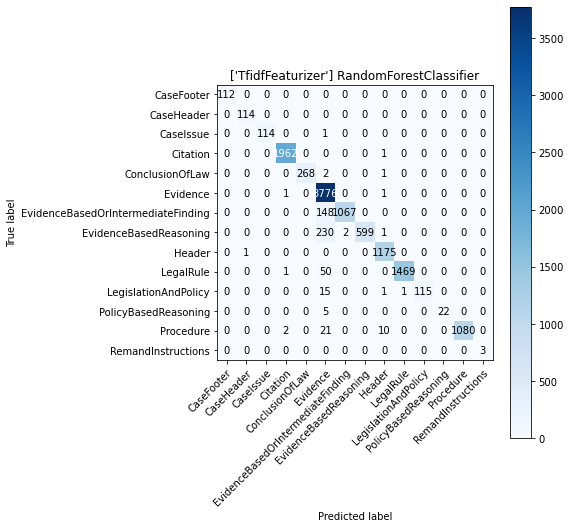

[TfidfFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.98      0.97      0.98       247
                   ConclusionOfLaw       0.86      0.71      0.78        35
                          Evidence       0.66      0.99      0.79       421
EvidenceBasedOrIntermediateFinding       0.68      0.49      0.57       134
            EvidenceBasedReasoning       0.50      0.04      0.07       141
                            Header       0.99      0.99      0.99       151
                         LegalRule       0.89      0.80      0.84       230
              LegislationAndPolicy       0.46      0.35      0.40        17
              PolicyBasedReasoning       0.00      0.00      0.0

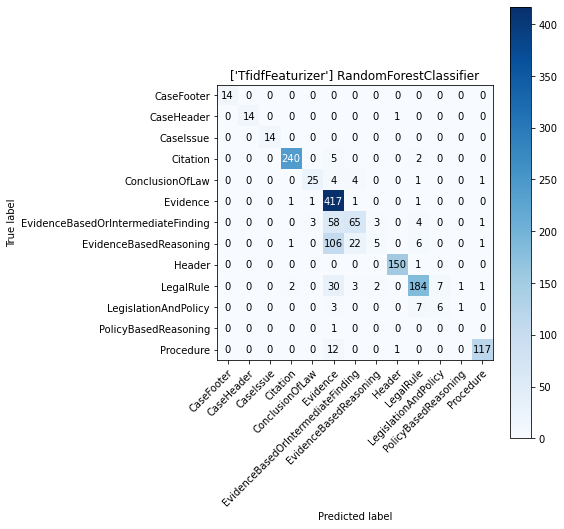

----------------------------------------------------------------------------------------------------
[EmbeddingsFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       0.99      1.00      1.00       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1963
                   ConclusionOfLaw       1.00      1.00      1.00       271
                          Evidence       1.00      1.00      1.00      3778
EvidenceBasedOrIntermediateFinding       1.00      1.00      1.00      1215
            EvidenceBasedReasoning       1.00      1.00      1.00       832
                            Header       1.00      1.00      1.00      1176
                         LegalRule       1.00      1.00      1.00      1520
              LegislationAndPoli

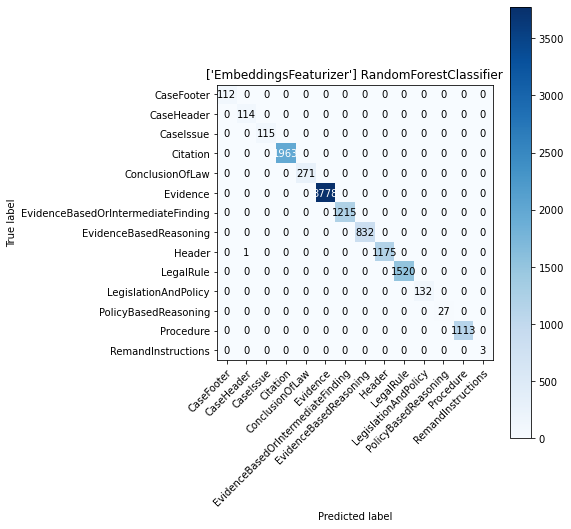

[EmbeddingsFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.98      0.97      0.97       247
                   ConclusionOfLaw       0.93      0.74      0.83        35
                          Evidence       0.77      0.96      0.85       421
EvidenceBasedOrIntermediateFinding       0.56      0.57      0.56       134
            EvidenceBasedReasoning       0.50      0.11      0.18       141
                            Header       0.99      0.99      0.99       151
                         LegalRule       0.82      0.87      0.84       230
              LegislationAndPolicy       0.38      0.35      0.36        17
              PolicyBasedReasoning       0.00      0.00    

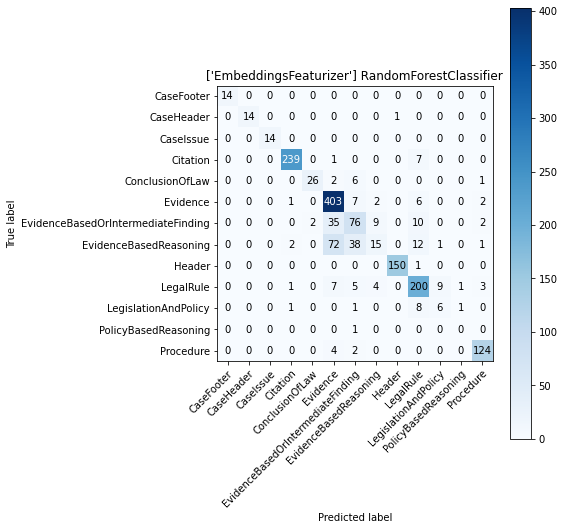

----------------------------------------------------------------------------------------------------
The best Random Forest Classifier for EmbeddingsFeaturizer:


/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[TfidfFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.90      0.95       115
                          Citation       0.99      0.98      0.99      1963
                   ConclusionOfLaw       0.98      0.42      0.59       271
                          Evidence       0.58      1.00      0.73      3778
EvidenceBasedOrIntermediateFinding       0.95      0.27      0.42      1215
            EvidenceBasedReasoning       1.00      0.02      0.03       832
                            Header       0.92      0.98      0.95      1176
                         LegalRule       0.94      0.71      0.81      1520
              LegislationAndPolicy       1.00      0.13      0.23       132
              PolicyBasedReasoning       1.00      0.11      0

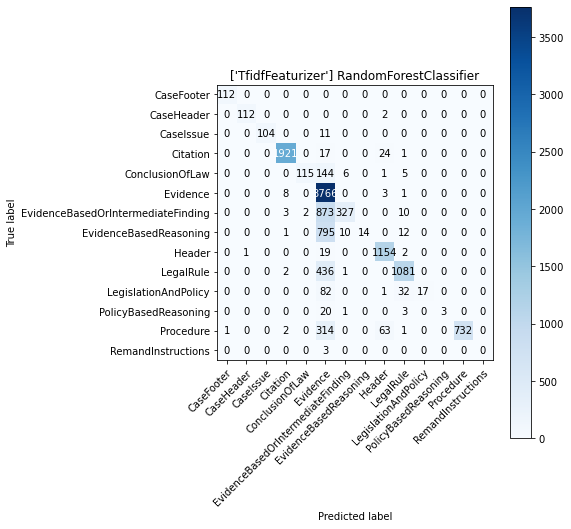

/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/batuhanerden/opt/anaconda3/envs/ldsi/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[TfidfFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.93      0.96        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      0.79      0.88        14
                          Citation       0.98      0.96      0.97       247
                   ConclusionOfLaw       1.00      0.29      0.44        35
                          Evidence       0.52      0.99      0.68       421
EvidenceBasedOrIntermediateFinding       0.78      0.16      0.26       134
            EvidenceBasedReasoning       0.00      0.00      0.00       141
                            Header       0.87      0.98      0.92       151
                         LegalRule       0.90      0.68      0.77       230
              LegislationAndPolicy       0.33      0.06      0.10        17
              PolicyBasedReasoning       0.00      0.00      0.0

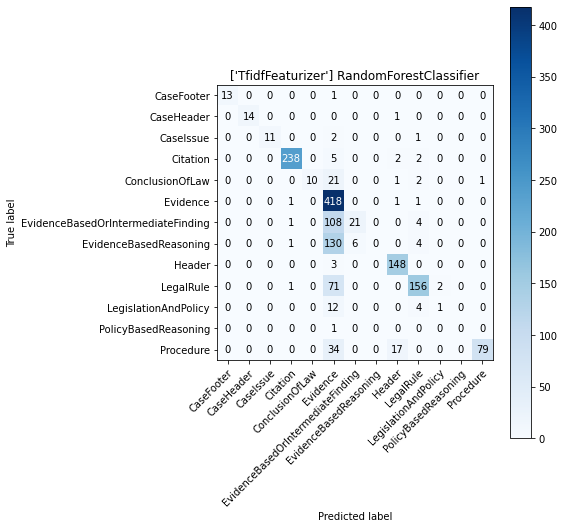

----------------------------------------------------------------------------------------------------
[EmbeddingsFeaturizer] train:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       0.99      1.00      1.00       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      1.00      1.00      1963
                   ConclusionOfLaw       1.00      0.97      0.98       271
                          Evidence       0.90      1.00      0.95      3778
EvidenceBasedOrIntermediateFinding       0.96      0.87      0.91      1215
            EvidenceBasedReasoning       1.00      0.73      0.84       832
                            Header       1.00      1.00      1.00      1176
                         LegalRule       0.97      0.99      0.98      1520
              LegislationAndPoli

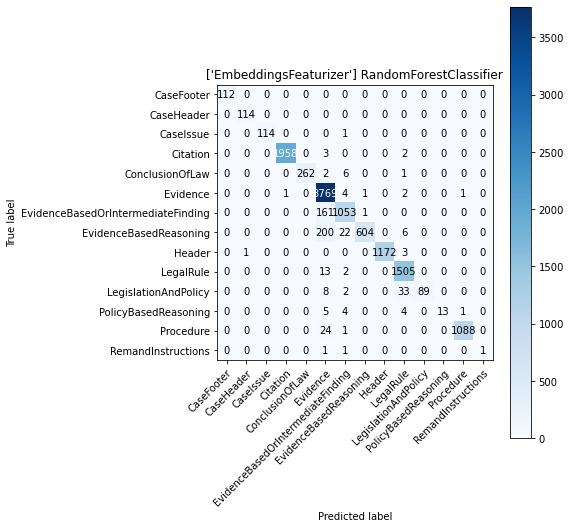

[EmbeddingsFeaturizer] val:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      0.93      0.97        15
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.98      0.96      0.97       247
                   ConclusionOfLaw       0.92      0.63      0.75        35
                          Evidence       0.74      0.95      0.84       421
EvidenceBasedOrIntermediateFinding       0.55      0.57      0.56       134
            EvidenceBasedReasoning       0.42      0.06      0.10       141
                            Header       0.99      0.99      0.99       151
                         LegalRule       0.81      0.87      0.84       230
              LegislationAndPolicy       0.50      0.35      0.41        17
              PolicyBasedReasoning       0.00      0.00    

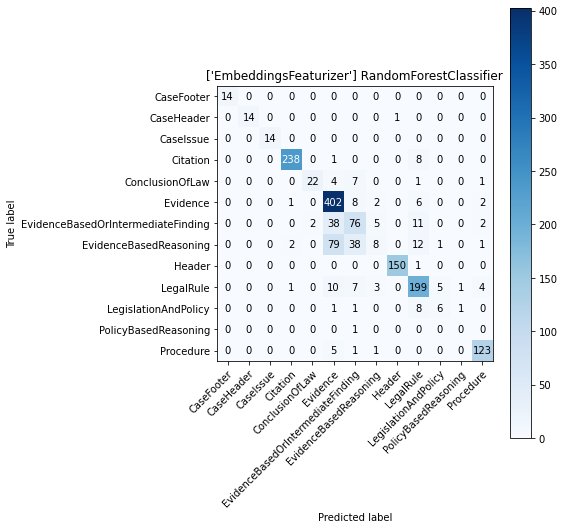

----------------------------------------------------------------------------------------------------


In [152]:
# Random Forest Classifiers based on the featurizer
classifier_random_forests = {
    "TfidfFeaturizer": RandomForestClassifier(
        n_estimators=800, max_depth=35, bootstrap=True),
    "EmbeddingsFeaturizer": RandomForestClassifier(
        n_estimators=100, max_depth=15, bootstrap=True)
}

print("The best Random Forest Classifier for TfidfFeaturizer:")
test_classifier(classifier_random_forests["TfidfFeaturizer"], X, y)

print("The best Random Forest Classifier for EmbeddingsFeaturizer:")
test_classifier(classifier_random_forests["EmbeddingsFeaturizer"], X, y)

## Step 5.4: Model Training on the test set with the best models

In [ ]:
print("The best Random Forest Classifier for TfidfFeaturizer:")
test_classifier(classifier_random_forests["TfidfFeaturizer"], X, y, use_test_set=True)

print("The best Random Forest Classifier for EmbeddingsFeaturizer:")
test_classifier(classifier_random_forests["EmbeddingsFeaturizer"], X, y, use_test_set=True)

## Step 5.5: Train and save the best classifier

In [157]:
# Train the best classifier
best_classifier = classifier_random_forests["EmbeddingsFeaturizer"]
best_classifier.fit(X["EmbeddingsFeaturizer"]["train"], y["EmbeddingsFeaturizer"]["train"])

# Save the best classifier
pickle.dump(best_classifier, open(BEST_CLASSIFIER_FILEPATH, "wb"))

# Step 6: Error Analysis